## Image Processing with Convolutional Neural Network(CNN)

In this project, I will build an end-to-end machine learning solution using a convolutional neural network(CNN) for house price prediction problem via TensorFlow. 


The dataset contains 535 house images showing 4 different parts of each house (bathroom, livingroom, exterior, kitchen) and the aim is to predict the price of each house by using the images provided. Mean Squared Error(MSE), Mean Absolute Error(MAE), and Mean Absolute Percent Error(MAPE) are used as evaluation metrics. I will also try to share the reasoning behind my choices.

We will go through 5 steps: 

 1) **Preparing Libraries and Data:** Obtaining the dataset <br>
 2) **Preprocessing the Data:** Dealing with pixels and scaling the target<br>
 3) **Evaluation Metric and Base Score:** Evaluation metrics and base score assumption<br>
 4) **Building the Convolutional Neural Network for Regression:** Implementing TensorFlow CNN model<br>
 5) **Model Results and Evaluation:** Making comments on the model results



### 1) Preparing Libraries and Data

In [1]:
# Common libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt

2023-02-08 22:03:25.791074: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Obtaining the data from local folder
def load_house_images(data_path, house_count, image_size):
    house_images = np.zeros((house_count, 2 * image_size[0], 2 * image_size[1], 3),
                             dtype = "uint8")
    for i in range(house_count):
        bathroom = image.load_img("./{}/{}_bathroom.jpg".format(data_path, i + 1),
                                  target_size = image_size)
        house_images[i, 0:image_size[0], 0:image_size[1], :] = bathroom
        bedroom = image.load_img("./{}/{}_bedroom.jpg".format(data_path, i + 1),
                                 target_size = image_size)
        house_images[i, 0:image_size[0], image_size[1]:(2 * image_size[1]), :] = bedroom
        frontal = image.load_img("./{}/{}_frontal.jpg".format(data_path, i + 1),
                                  target_size = image_size)
        house_images[i, image_size[0]:(2 * image_size[0]), 0:image_size[1], :] = frontal
        kitchen = image.load_img("./{}/{}_kitchen.jpg".format(data_path, i + 1),
                                 target_size = image_size)
        house_images[i, image_size[0]:(2 * image_size[0]), image_size[1]:(2 * image_size[1]), :] = kitchen
    return house_images

def load_house_prices(data_path):
    houses_info = np.loadtxt("./{}/HousesInfo.txt".format(data_path))
    return houses_info[:, 4]

In [3]:
house_images = load_house_images("HD", 535, (128, 128))
print(house_images.shape)

(535, 256, 256, 3)


In [4]:
house_prices = load_house_prices("HD")
print(house_prices.shape)

(535,)


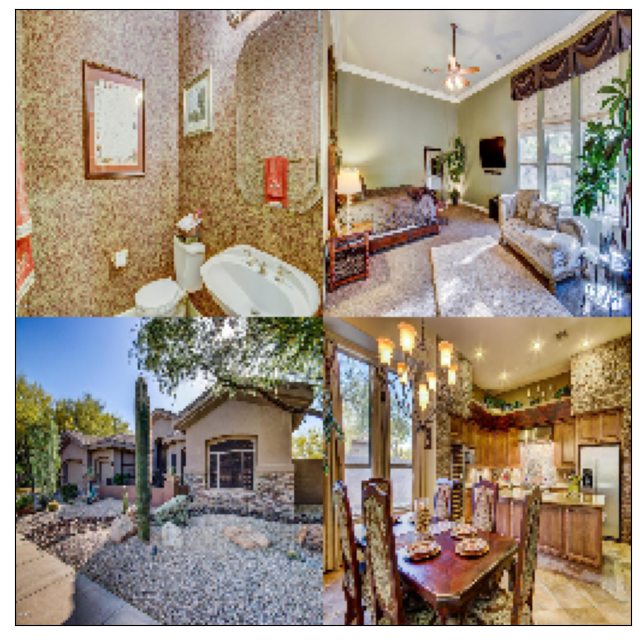

869500.0


In [5]:
#display the first house's picture 
plt.figure(figsize = (8, 8))
plt.imshow(house_images[0, :, :, :])
plt.xticks([])
plt.yticks([])
plt.show()
#display the first house's price 
print(house_prices[0])

### 2) Preprocessing the Data

We have 535 pictures in total. Dimensions are 256x256 and we have 3 channels for colors. Before we start, it is a good idea to scale the data by dividing with 255 which is the pixel value of white color. 

House prices (y) is also scaled by dividing with its maximum value to improve model performances. 

In [10]:
# Additional libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import pandas as pd

# Data Viz.
import plotly.express as px
import seaborn as sns

In [11]:
X = house_images / 255
y = house_prices

# Getting training and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,
                                              test_size = 0.2,
                                              random_state = 1234,
                                              shuffle = True)

print(f'Xtrain shape: {Xtrain.shape}, ytrain shape: {ytrain.shape}\nXtest shape: {Xtest.shape}, ytest shape: {ytest.shape}\n')

# Scaling the prices by dividing with the maximum value.
ytrain_ns = ytrain.copy() #for metric calculations without scaling
ymax = np.max(ytrain)
ytrain = ytrain / ymax
ytest = ytest / ymax

# Getting learn and validation sets for CNN model.
Xlearn, Xval, ylearn, yval = train_test_split(Xtrain, ytrain,
                                              test_size = 0.25,
                                              random_state = 1234,
                                              shuffle = True)

print(f'Xlearn shape: {Xlearn.shape}, ylearn shape: {ylearn.shape}\nXvalidation shape: {Xval.shape}, yvalidation shape: {yval.shape}')


Xtrain shape: (428, 256, 256, 3), ytrain shape: (428,)
Xtest shape: (107, 256, 256, 3), ytest shape: (107,)

Xlearn shape: (321, 256, 256, 3), ylearn shape: (321,)
Xvalidation shape: (107, 256, 256, 3), yvalidation shape: (107,)


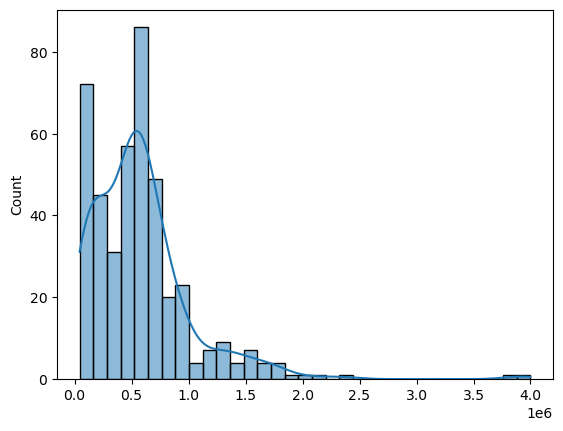

In [15]:
# Distribution of house prices for training set.
sns.histplot(data=ytrain_ns, kde=True)
plt.show()

### 3) Evaluation Metric and Base Score

Since we have outliers, only Mean Squared Error (MSE) can be misleading to evaluate the model. Therefore, Mean Absolute (MAE) and Mean Absolute Percentage Error (MAPE) are also used for the evaluation. Moreover, MAPE is more robust for outliers than the others and more understandable. 

Before we start building a CNN Model, I wanted to learn the training base MSE, MAE, and MAPE values for both scaled and original data. 

In [16]:
# BASE METRICS 
# I assume all prices are equal to the median value.
y_base = np.full(ytrain.shape,fill_value=np.median(ytrain))
y_base_ns = np.full(ytrain.shape,fill_value=np.median(ytrain_ns)) #for Mean Absolute Percent Error calculation without scaling

# Base MSE and MAE (not scaled)
base_mse = round(mean_squared_error(ytrain,y_base),4)
base_mae = round(mean_absolute_error(ytrain,y_base),4)
base_mape = round(mean_absolute_percentage_error(ytrain,y_base)*100,2)
print(f'Scaled MSE: {base_mse}, Scaled MAE: {base_mae}, Scaled MAPE: {base_mape}')

base_mse_ns = round(mean_squared_error(ytrain_ns,y_base_ns),2)
base_mae_ns = round(mean_absolute_error(ytrain_ns,y_base_ns),2)
base_mape_ns = round(mean_absolute_percentage_error(ytrain_ns,y_base_ns)*100,2)
print(f'Original MSE: {base_mse_ns}, Original MAE: {base_mae_ns}, Original MAPE: {base_mape_ns}')


Scaled MSE: 0.0132, Scaled MAE: 0.0748, Scaled MAPE: 117.42
Original MSE: 211651949674.59, Original MAE: 299011.92, Original MAPE: 117.42


### 4) Building the Convolutional Neural Network for Regression

Unit activation was used at the output layer and the loss function was selected as mean squared error (MSE), since our problem is regression. To avoid overfitting, Dropout layers and regularization were added.



In [17]:
# for dynamic model input
input_shape = (Xtrain.shape[1],Xtrain.shape[2],Xtrain.shape[3])

def my_cnn_model(input_shape = input_shape):
    # model architecture part
    model = keras.models.Sequential()
    model.add(keras.layers.Input(name="Input", shape = input_shape))
    
    model.add(keras.layers.Conv2D(name="First_Conv_Layer", filters = 64, kernel_size = (3, 3), strides = 1, padding="same"))
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.Dropout(0.2, seed=1234)) # dropout layer to deal with overfitting and seed is intentionally added to stabilize the results (it can be removed)
    model.add(keras.layers.MaxPool2D(pool_size = (2, 2), strides = 2))

    model.add(keras.layers.Conv2D(name="Second_Conv_Layer", filters = 32, kernel_size = (3, 3), strides = 1, padding="same"))
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.Dropout(0.2, seed=1234)) # dropout layer to deal with overfitting and seed is intentionally added to stabilize the results (it can be removed)
    model.add(keras.layers.MaxPool2D(pool_size = (2, 2), strides = 2))
    
    model.add(keras.layers.Flatten()) # for MLP, we need 1 dimensional data. That's why flatten is used.
    model.add(keras.layers.Dense(32, name="First_ReLu", activation = "relu")) 
    model.add(keras.layers.Dropout(0.2)) # dropout layer to deal with overfitting
    
    model.add(keras.layers.Dense(16, name="Second_ReLu", activation = "relu"))
    model.add(keras.layers.Dropout(0.2)) # dropout layer to deal with overfitting
    
    # Ridge Regularization is added to avoid overfitting. Lasso and Elastic Net regularizations were also tried. 
    model.add(keras.layers.Dense(1, kernel_regularizer = keras.regularizers.l2(l2 = 0.0001))) # since it is a regression problem, unit activation is used.

    # compile part
    model.compile(loss = "mean_squared_error", # since we have a regression problem, mean_squared_error is used.
                  optimizer = keras.optimizers.Adam(learning_rate = 0.0001), # Adam optimizer is kind of gradient descent approach with some momentum
                  metrics=['mae', 'mape']) # metrics to be tracked

    return model

In [18]:
# Model summary
CNN_model = my_cnn_model()

CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 First_Conv_Layer (Conv2D)   (None, 256, 256, 64)      1792      
                                                                 
 activation (Activation)     (None, 256, 256, 64)      0         
                                                                 
 dropout (Dropout)           (None, 256, 256, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 Second_Conv_Layer (Conv2D)  (None, 128, 128, 32)      18464     
                                                                 
 activation_1 (Activation)   (None, 128, 128, 32)      0         
                                                        

2023-02-08 22:06:07.147768: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
# Early stop criteria to optimize the resources
early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                           restore_best_weights = True, # restore is important. It will support the best ones instead of the last ones
                                           patience = 10,
                                           mode = "auto")

# Model fit part
cnn_history = CNN_model.fit(Xlearn, ylearn,
                              epochs = 100,
                              batch_size = 32,
                              verbose = 1,
                              validation_data = (Xval, yval),
                              callbacks = [early_stop])

Epoch 1/100
11/11 [==============================] - 14s 1s/step - loss: 0.0489 - mae: 0.1631 - mape: 188.4050 - val_loss: 0.0232 - val_mae: 0.1206 - val_mape: 72.8311
Epoch 2/100
11/11 [==============================] - 13s 1s/step - loss: 0.0372 - mae: 0.1222 - mape: 116.2888 - val_loss: 0.0232 - val_mae: 0.1205 - val_mape: 72.8224
Epoch 3/100
11/11 [==============================] - 13s 1s/step - loss: 0.0302 - mae: 0.1234 - mape: 110.5944 - val_loss: 0.0246 - val_mae: 0.1253 - val_mape: 75.2566
Epoch 4/100
11/11 [==============================] - 13s 1s/step - loss: 0.0272 - mae: 0.1176 - mape: 110.3665 - val_loss: 0.0256 - val_mae: 0.1288 - val_mape: 77.7469
Epoch 5/100
11/11 [==============================] - 13s 1s/step - loss: 0.0296 - mae: 0.1189 - mape: 86.1898 - val_loss: 0.0253 - val_mae: 0.1279 - val_mape: 77.0363
Epoch 6/100
11/11 [==============================] - 13s 1s/step - loss: 0.0227 - mae: 0.1025 - mape: 77.4530 - val_loss: 0.0231 - val_mae: 0.1202 - val_mape: 72

### 4) Model Results and Evaluation

In [20]:
# evaluation part
print(f'Base Scaled MSE: {base_mse}, Base Scaled MAE: {base_mae}, Base Scaled MAPE: {base_mape}')
print("--------------Learn set results--------------")
CNN_model.evaluate(Xlearn, ylearn)
print("--------------Validation set results--------------")
CNN_model.evaluate(Xval, yval)
print("--------------Test set results--------------")
CNN_model.evaluate(Xtest, ytest)

Base Scaled MSE: 0.0132, Base Scaled MAE: 0.0748, Base Scaled MAPE: 117.42
--------------Learn set results--------------
11/11 [==============================] - 3s 230ms/step - loss: 0.0138 - mae: 0.0711 - mape: 62.5983
--------------Validation set results--------------
4/4 [==============================] - 1s 210ms/step - loss: 0.0109 - mae: 0.0757 - mape: 72.9130
--------------Test set results--------------
4/4 [==============================] - 1s 214ms/step - loss: 0.0334 - mae: 0.0973 - mape: 79.1082


[0.033429358154535294, 0.09729693830013275, 79.10818481445312]

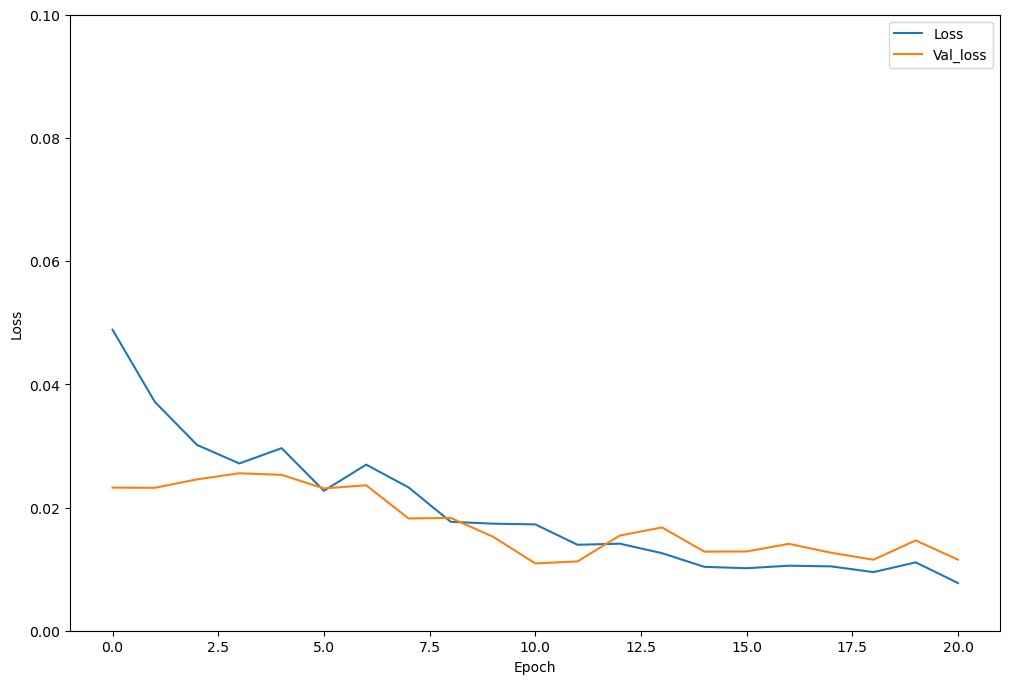

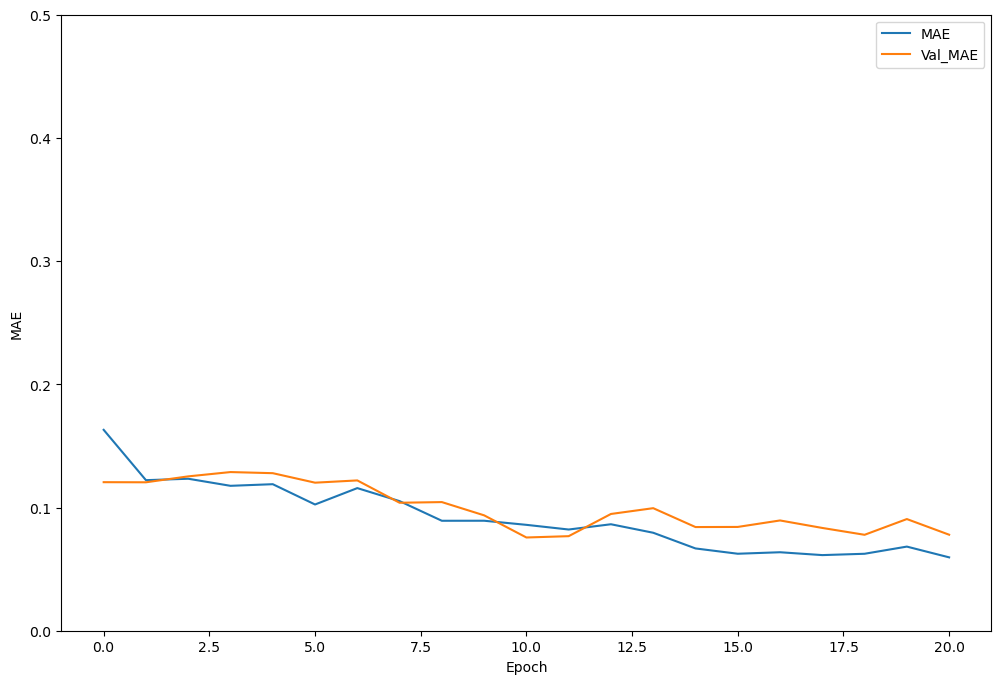

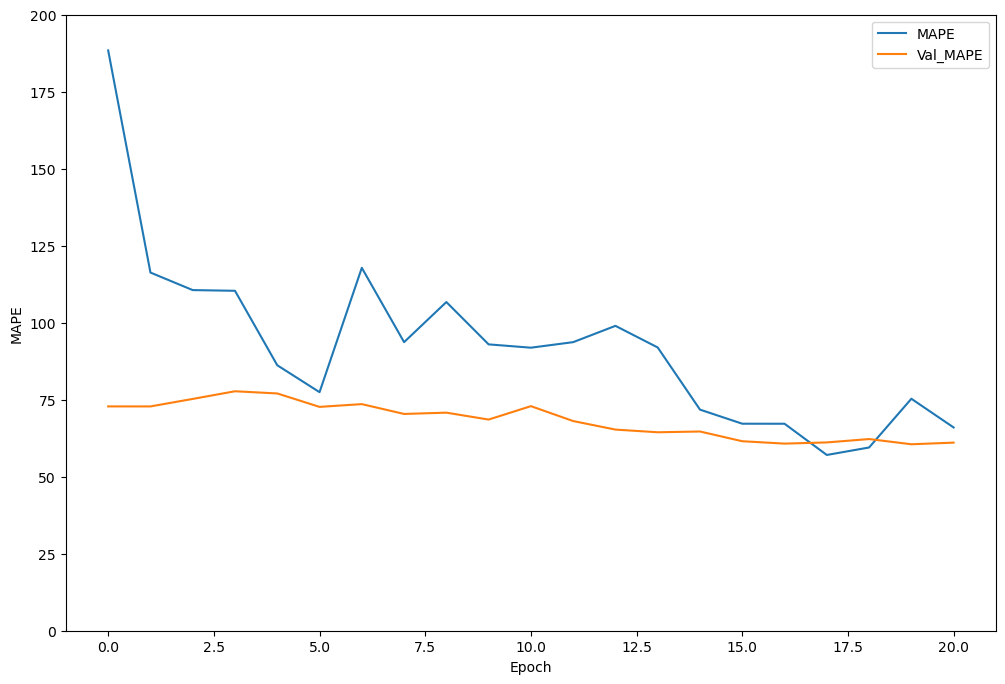

In [21]:
# Plotting the metrics for evaluation
# For loss function
plt.figure(figsize=(12,8))
plt.plot(cnn_history.history['loss'], label="Loss")
plt.plot(cnn_history.history['val_loss'], label="Val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0,0.1)
plt.legend()
plt.show()

# For MAE metric
plt.figure(figsize=(12,8))
plt.plot(cnn_history.history['mae'], label="MAE")
plt.plot(cnn_history.history['val_mae'], label="Val_MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.ylim(0,0.5)
plt.legend()
plt.show()

# For MAPE metric
plt.figure(figsize=(12,8))
plt.plot(cnn_history.history['mape'], label="MAPE")
plt.plot(cnn_history.history['val_mape'], label="Val_MAPE")
plt.xlabel("Epoch")
plt.ylabel("MAPE")
plt.ylim(0,200)
plt.legend()
plt.show()


#### Evaluation Comments

*   While our base MSE and MAPE are 0.0132 and 117.42 respectively, The CNN Model has lower both MSE (learn MSE: 0.0086, test MSE: 0.0322) and MAPE (learn MAPE: 45.68, test MAPE: 79.95)
*   To deal with overfitting, dropout layers and Ridge regularization were used. However, overfitting is still a issue as seen in the graphs. 
*   More training data are needed to improve the test results.
*   Scaling the target improved the model performance. However, min-max scaling were not used to get healthy MAPE results.
*   Early stopping was used to prevent computation overload.
*   Because of initialization, each run can support different results. Sometimes I got the validation MAPE lower than 50%.


14/14 [==============================] - 4s 256ms/step
MSE: 205951163057.21, MAE: 289026.92, MAPE: 65.18


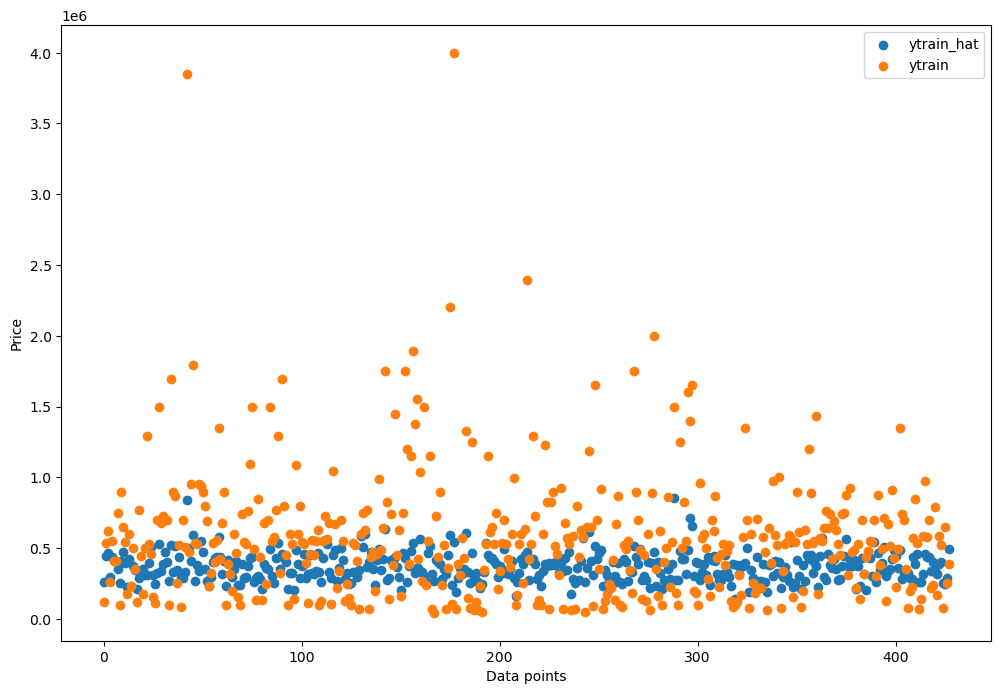

In [22]:
# Plotting Data Points to evalute the results
# prediction 
ytrain_hat = CNN_model.predict(Xtrain)
y_train_hat_inv = ytrain_hat*ymax
y_train_original = ytrain*ymax

# Real MSE and MAE (not scaled)
real_mse = round(mean_squared_error(y_train_original,y_train_hat_inv),2)
real_mae = round(mean_absolute_error(y_train_original,y_train_hat_inv),2)
real_mape = round(mean_absolute_percentage_error(y_train_original,y_train_hat_inv)*100,2)
print(f'MSE: {real_mse}, MAE: {real_mae}, MAPE: {real_mape}')

# plotting predicted and original values
plt.figure(figsize=(12,8))
plt.scatter(np.arange(len(y_train_hat_inv)), y_train_hat_inv, label="ytrain_hat")
plt.scatter(np.arange(len(y_train_hat_inv)), y_train_original, label="ytrain")
plt.xlabel("Data points")
plt.ylabel("Price")
plt.legend()
plt.show()

4/4 [==============================] - 1s 205ms/step
Test MSE: 531748945423.97, Test MAE: 389187.77, Test MAPE: 79.11


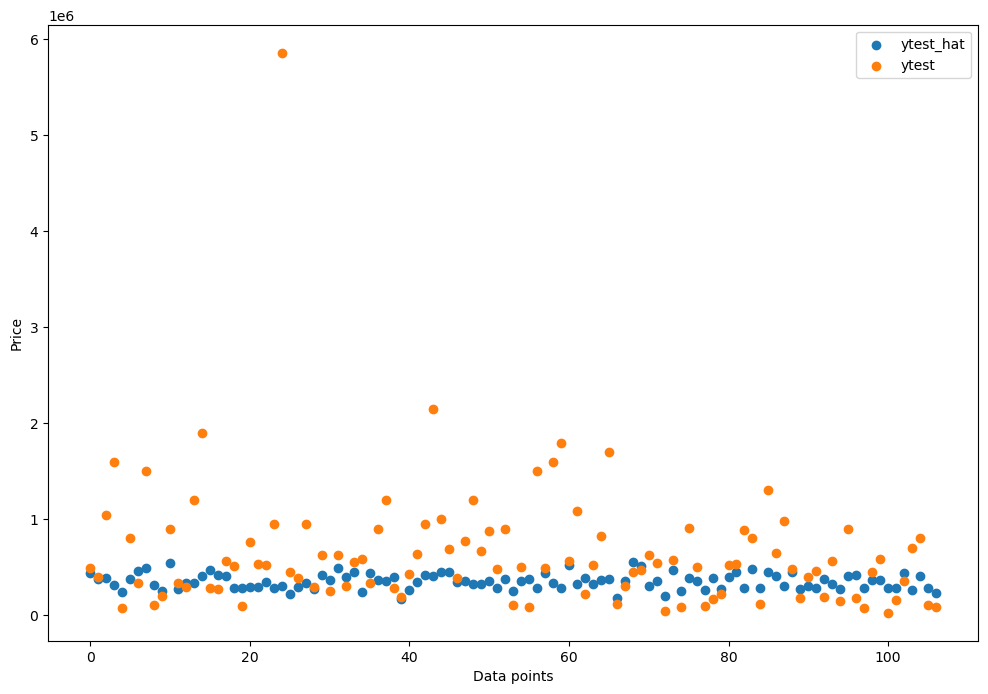

In [23]:
# prediction 
ytest_hat = CNN_model.predict(Xtest)
y_test_hat_inv = ytest_hat*ymax
y_test_original = ytest*ymax

# Real MSE and MAE (not scaled)
real_mse = round(mean_squared_error(y_test_original,y_test_hat_inv),2)
real_mae = round(mean_absolute_error(y_test_original,y_test_hat_inv),2)
real_mape = round(mean_absolute_percentage_error(y_test_original,y_test_hat_inv)*100,2)
print(f'Test MSE: {real_mse}, Test MAE: {real_mae}, Test MAPE: {real_mape}')

# plotting predicted and original values
plt.figure(figsize=(12,8))
plt.scatter(np.arange(len(y_test_hat_inv)), y_test_hat_inv, label="ytest_hat")
plt.scatter(np.arange(len(y_test_hat_inv)), y_test_original, label="ytest")
plt.xlabel("Data points")
plt.ylabel("Price")
plt.legend()
plt.show()

#### Evaluation Comments Cont'

*   When we look at the training data points, some outliers can be seen in the predicted values (ytrain_hat). However, for the test set, we do not see many outliers for the predicted values(ytest_hat). The model should learn more with new training data sets. Maybe some data augmentation methods can be used or more training data can be provided.
